# Task 4: Statistical Modeling

**Project**: AlphaCare Insurance Solutions - Risk Analytics  
**Objective**: Build and evaluate predictive models for risk-based pricing

---

## Modeling Goals

1. **Charge Prediction (Risk Model)**: Predict insurance charges using regression
2. **Risk Classification**: Classify high-risk vs low-risk policyholders
3. **Feature Importance**: Identify top risk drivers using SHAP

## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

# XGBoost
try:
    from xgboost import XGBRegressor, XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. Run: pip install xgboost")

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed. Run: pip install shap")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"SHAP available: {SHAP_AVAILABLE}")

XGBoost not installed. Run: pip install xgboost
SHAP not installed. Run: pip install shap
Libraries loaded successfully!
XGBoost available: False
SHAP available: False


In [2]:
# Load data
df = pd.read_csv('../data/insurance.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset Shape: (1338, 7)

Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Data Preparation

In [3]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")

Missing Values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Total missing: 0


In [4]:
# Feature Engineering
print("="*60)
print("                  FEATURE ENGINEERING")
print("="*60)

# 1. BMI Categories
df['bmi_category'] = pd.cut(df['bmi'], 
                            bins=[0, 18.5, 25, 30, 100],
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 2. Age Groups
df['age_group'] = pd.cut(df['age'], 
                         bins=[17, 30, 45, 60, 100],
                         labels=['18-30', '31-45', '46-60', '60+'])

# 3. Smoker-BMI Interaction (high risk factor)
df['smoker_bmi'] = (df['smoker'] == 'yes').astype(int) * df['bmi']

# 4. Age-Smoker Interaction
df['age_smoker'] = (df['smoker'] == 'yes').astype(int) * df['age']

# 5. High Risk Flag (charges > median)
df['high_risk'] = (df['charges'] > df['charges'].median()).astype(int)

print("\n✅ New features created:")
print("   - bmi_category: BMI classification")
print("   - age_group: Age bracket")
print("   - smoker_bmi: Smoker × BMI interaction")
print("   - age_smoker: Age × Smoker interaction")
print("   - high_risk: Binary target (charges > median)")

print(f"\nNew shape: {df.shape}")
df.head()

                  FEATURE ENGINEERING

✅ New features created:
   - bmi_category: BMI classification
   - age_group: Age bracket
   - smoker_bmi: Smoker × BMI interaction
   - age_smoker: Age × Smoker interaction
   - high_risk: Binary target (charges > median)

New shape: (1338, 12)


,age,sex,bmi,children,smoker,region,charges,bmi_category,age_group,smoker_bmi,age_smoker,high_risk
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight,18-30,27.9,19,1
1,18,male,33.770,1,no,southeast,1725.55230,Obese,18-30,0.0,0,0
2,28,male,33.000,3,no,southeast,4449.46200,Obese,18-30,0.0,0,0
3,33,male,22.705,0,no,northwest,21984.47061,Normal,31-45,0.0,0,1
4,32,male,28.880,0,no,northwest,3866.85520,Overweight,31-45,0.0,0,0


In [5]:
# Encode categorical variables
print("\nEncoding Categorical Variables...")

# Create a copy for modeling
df_model = df.copy()

# Binary encoding for smoker and sex
df_model['smoker_encoded'] = (df_model['smoker'] == 'yes').astype(int)
df_model['sex_encoded'] = (df_model['sex'] == 'male').astype(int)

# One-hot encoding for region
region_dummies = pd.get_dummies(df_model['region'], prefix='region')
df_model = pd.concat([df_model, region_dummies], axis=1)

# One-hot encoding for bmi_category
bmi_dummies = pd.get_dummies(df_model['bmi_category'], prefix='bmi_cat')
df_model = pd.concat([df_model, bmi_dummies], axis=1)

# One-hot encoding for age_group
age_dummies = pd.get_dummies(df_model['age_group'], prefix='age_grp')
df_model = pd.concat([df_model, age_dummies], axis=1)

print(f"\n✅ Encoded dataset shape: {df_model.shape}")
print(f"\nNew columns: {df_model.columns.tolist()}")


Encoding Categorical Variables...

✅ Encoded dataset shape: (1338, 26)

New columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'bmi_category', 'age_group', 'smoker_bmi', 'age_smoker', 'high_risk', 'smoker_encoded', 'sex_encoded', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'bmi_cat_Underweight', 'bmi_cat_Normal', 'bmi_cat_Overweight', 'bmi_cat_Obese', 'age_grp_18-30', 'age_grp_31-45', 'age_grp_46-60', 'age_grp_60+']


In [6]:
# Prepare features for modeling
feature_cols = ['age', 'bmi', 'children', 'smoker_encoded', 'sex_encoded',
                'smoker_bmi', 'age_smoker',
                'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']

X = df_model[feature_cols]
y_reg = df_model['charges']  # Regression target
y_clf = df_model['high_risk']  # Classification target

print("Feature Matrix Shape:", X.shape)
print("Regression Target Shape:", y_reg.shape)
print("Classification Target Distribution:")
print(y_clf.value_counts())

Feature Matrix Shape: (1338, 11)
Regression Target Shape: (1338,)
Classification Target Distribution:
high_risk
1    669
0    669
Name: count, dtype: int64


In [7]:
# Train-Test Split (80:20)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

_, _, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data preparation complete!")

Training set: 1070 samples
Test set: 268 samples

✅ Data preparation complete!


## 3. Model Building - Regression

**Target**: Predict insurance charges (continuous)

In [8]:
# Initialize models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

if XGBOOST_AVAILABLE:
    regression_models['XGBoost'] = XGBRegressor(
        n_estimators=100, max_depth=6, learning_rate=0.1, 
        random_state=42, verbosity=0
    )

# Store results
reg_results = []

print("="*70)
print("                    REGRESSION MODEL TRAINING")
print("="*70)

                    REGRESSION MODEL TRAINING


In [9]:
# Train and evaluate each model
trained_reg_models = {}

for name, model in regression_models.items():
    print(f"\n📊 Training {name}...")
    
    # Use scaled data for Linear Regression
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train_reg)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train_reg)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)
    mae = mean_absolute_error(y_test_reg, y_pred)
    
    # Cross-validation
    if name == 'Linear Regression':
        cv_scores = cross_val_score(model, X_train_scaled, y_train_reg, cv=5, scoring='r2')
    else:
        cv_scores = cross_val_score(model, X_train, y_train_reg, cv=5, scoring='r2')
    
    print(f"   RMSE: ${rmse:,.2f}")
    print(f"   R²: {r2:.4f}")
    print(f"   MAE: ${mae:,.2f}")
    print(f"   CV R² (mean): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    reg_results.append({
        'Model': name,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std()
    })
    
    trained_reg_models[name] = model

# Results DataFrame
reg_results_df = pd.DataFrame(reg_results).sort_values('R²', ascending=False)
print("\n" + "="*70)
print("              REGRESSION MODEL COMPARISON")
print("="*70)
print(reg_results_df.to_string(index=False))


📊 Training Linear Regression...
   RMSE: $4,574.12
   R²: 0.8652
   MAE: $2,757.76
   CV R² (mean): 0.8279 ± 0.0452

📊 Training Decision Tree...
   RMSE: $5,789.94
   R²: 0.7841
   MAE: $2,969.89
   CV R² (mean): 0.7294 ± 0.0612

📊 Training Random Forest...


   RMSE: $4,551.01
   R²: 0.8666
   MAE: $2,517.74
   CV R² (mean): 0.8323 ± 0.0420

              REGRESSION MODEL COMPARISON
            Model        RMSE       R²         MAE  CV_R2_Mean  CV_R2_Std
    Random Forest 4551.013126 0.866590 2517.744139    0.832332   0.042047
Linear Regression 4574.123734 0.865232 2757.759204    0.827932   0.045190
    Decision Tree 5789.938300 0.784067 2969.894757    0.729428   0.061228


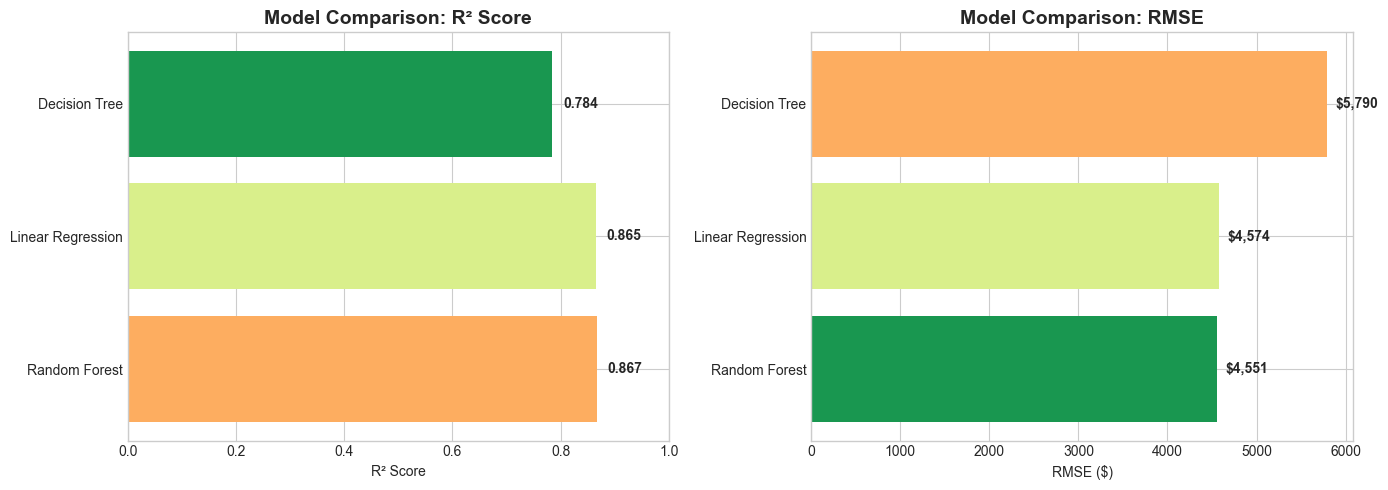

✅ Saved: model_regression_comparison.png


In [10]:
# Visualize regression results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(reg_results_df)))
bars = axes[0].barh(reg_results_df['Model'], reg_results_df['R²'], color=colors)
axes[0].set_xlabel('R² Score')
axes[0].set_title('Model Comparison: R² Score', fontweight='bold', fontsize=14)
axes[0].set_xlim(0, 1)
for bar, val in zip(bars, reg_results_df['R²']):
    axes[0].text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontweight='bold')

# RMSE comparison
bars2 = axes[1].barh(reg_results_df['Model'], reg_results_df['RMSE'], color=colors[::-1])
axes[1].set_xlabel('RMSE ($)')
axes[1].set_title('Model Comparison: RMSE', fontweight='bold', fontsize=14)
for bar, val in zip(bars2, reg_results_df['RMSE']):
    axes[1].text(val + 100, bar.get_y() + bar.get_height()/2, f'${val:,.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/model_regression_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: model_regression_comparison.png")

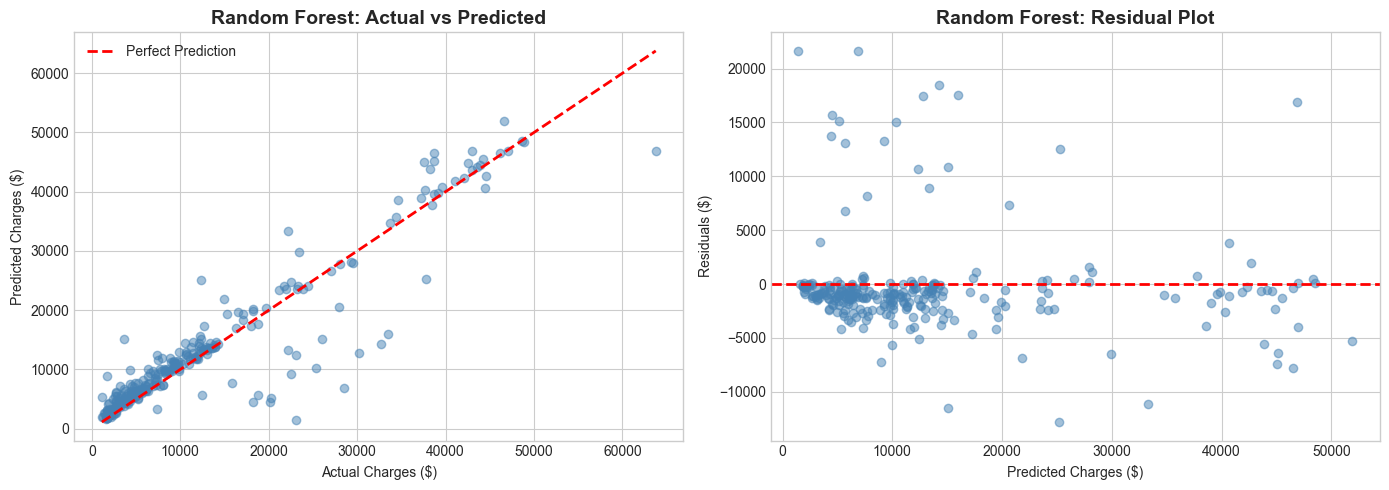

✅ Saved: model_best_regression_analysis.png


In [11]:
# Actual vs Predicted for best model
best_model_name = reg_results_df.iloc[0]['Model']
best_model = trained_reg_models[best_model_name]

if best_model_name == 'Linear Regression':
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test_reg, y_pred_best, alpha=0.5, color='steelblue')
axes[0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Charges ($)')
axes[0].set_ylabel('Predicted Charges ($)')
axes[0].set_title(f'{best_model_name}: Actual vs Predicted', fontweight='bold', fontsize=14)
axes[0].legend()

# Residuals
residuals = y_test_reg - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5, color='steelblue')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Charges ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title(f'{best_model_name}: Residual Plot', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('../reports/figures/model_best_regression_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: model_best_regression_analysis.png")

## 4. Model Building - Classification

**Target**: Predict high-risk (charges > median) vs low-risk

In [12]:
# Initialize classification models
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

if XGBOOST_AVAILABLE:
    classification_models['XGBoost'] = XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        random_state=42, verbosity=0, use_label_encoder=False, eval_metric='logloss'
    )

# Store results
clf_results = []

print("="*70)
print("                  CLASSIFICATION MODEL TRAINING")
print("="*70)

                  CLASSIFICATION MODEL TRAINING


In [13]:
# Train and evaluate each model
trained_clf_models = {}

for name, model in classification_models.items():
    print(f"\n📊 Training {name}...")
    
    # Use scaled data for Logistic Regression
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train_clf)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train_clf)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_clf, y_pred)
    precision = precision_score(y_test_clf, y_pred)
    recall = recall_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred)
    auc = roc_auc_score(y_test_clf, y_proba)
    
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   AUC-ROC: {auc:.4f}")
    
    clf_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc
    })
    
    trained_clf_models[name] = model

# Results DataFrame
clf_results_df = pd.DataFrame(clf_results).sort_values('AUC-ROC', ascending=False)
print("\n" + "="*70)
print("             CLASSIFICATION MODEL COMPARISON")
print("="*70)
print(clf_results_df.to_string(index=False))


📊 Training Logistic Regression...
   Accuracy: 0.9142
   Precision: 0.8898
   Recall: 0.9262
   F1-Score: 0.9076
   AUC-ROC: 0.9594

📊 Training Decision Tree...
   Accuracy: 0.9104
   Precision: 0.9016
   Recall: 0.9016
   F1-Score: 0.9016
   AUC-ROC: 0.9048

📊 Training Random Forest...
   Accuracy: 0.9366
   Precision: 0.9565
   Recall: 0.9016
   F1-Score: 0.9283
   AUC-ROC: 0.9514

             CLASSIFICATION MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.914179   0.889764 0.926230  0.907631 0.959353
      Random Forest  0.936567   0.956522 0.901639  0.928270 0.951437
      Decision Tree  0.910448   0.901639 0.901639  0.901639 0.904755


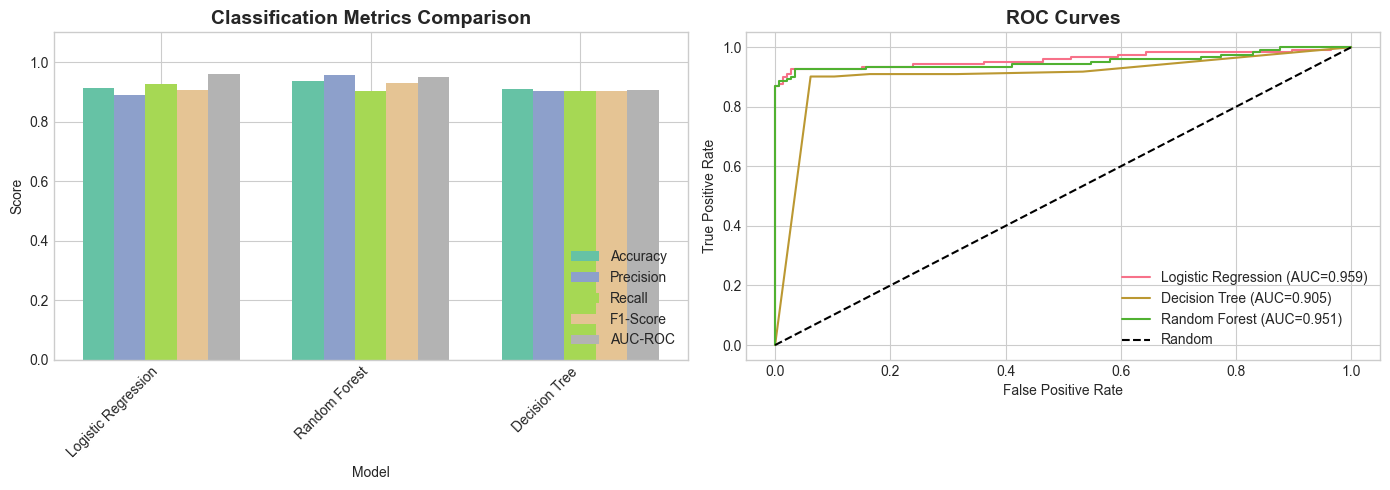

✅ Saved: model_classification_comparison.png


In [14]:
# Visualize classification results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(clf_results_df))
width = 0.15
colors = plt.cm.Set2(np.linspace(0, 1, 5))

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, clf_results_df[metric], width, label=metric, color=colors[i])

axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Classification Metrics Comparison', fontweight='bold', fontsize=14)
axes[0].set_xticks(x + width*2)
axes[0].set_xticklabels(clf_results_df['Model'], rotation=45, ha='right')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1.1)

# ROC Curves
for name, model in trained_clf_models.items():
    if name == 'Logistic Regression':
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    auc = roc_auc_score(y_test_clf, y_proba)
    axes[1].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves', fontweight='bold', fontsize=14)
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.savefig('../reports/figures/model_classification_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: model_classification_comparison.png")

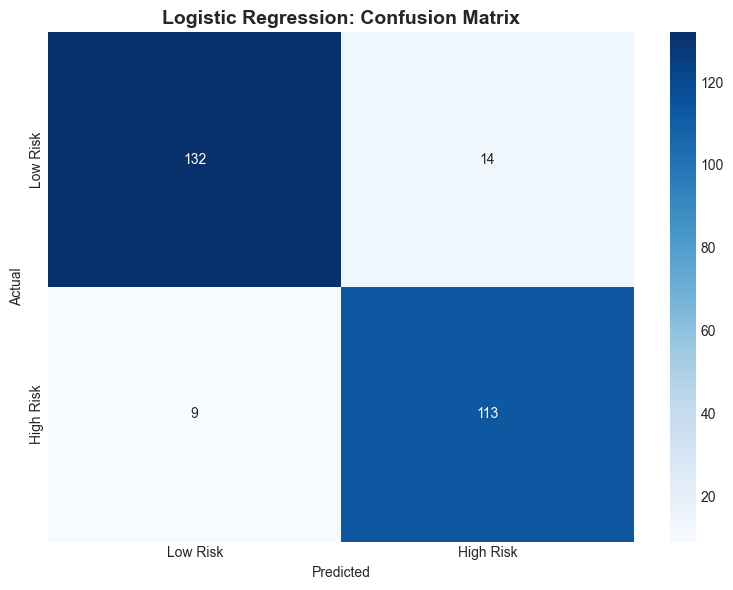


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.94      0.90      0.92       146
   High Risk       0.89      0.93      0.91       122

    accuracy                           0.91       268
   macro avg       0.91      0.92      0.91       268
weighted avg       0.92      0.91      0.91       268



In [15]:
# Confusion Matrix for best classifier
best_clf_name = clf_results_df.iloc[0]['Model']
best_clf = trained_clf_models[best_clf_name]

if best_clf_name == 'Logistic Regression':
    y_pred_clf = best_clf.predict(X_test_scaled)
else:
    y_pred_clf = best_clf.predict(X_test)

cm = confusion_matrix(y_test_clf, y_pred_clf)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'{best_clf_name}: Confusion Matrix', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('../reports/figures/model_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{best_clf_name} Classification Report:")
print(classification_report(y_test_clf, y_pred_clf, target_names=['Low Risk', 'High Risk']))

## 5. Feature Importance Analysis

                  FEATURE IMPORTANCE ANALYSIS

Random Forest Feature Importance:
         Feature  Importance
      smoker_bmi    0.772740
             age    0.115062
             bmi    0.046796
      age_smoker    0.024152
        children    0.017963
     sex_encoded    0.005006
region_northeast    0.004977
  smoker_encoded    0.004019
region_southeast    0.003518
region_northwest    0.003458
region_southwest    0.002309


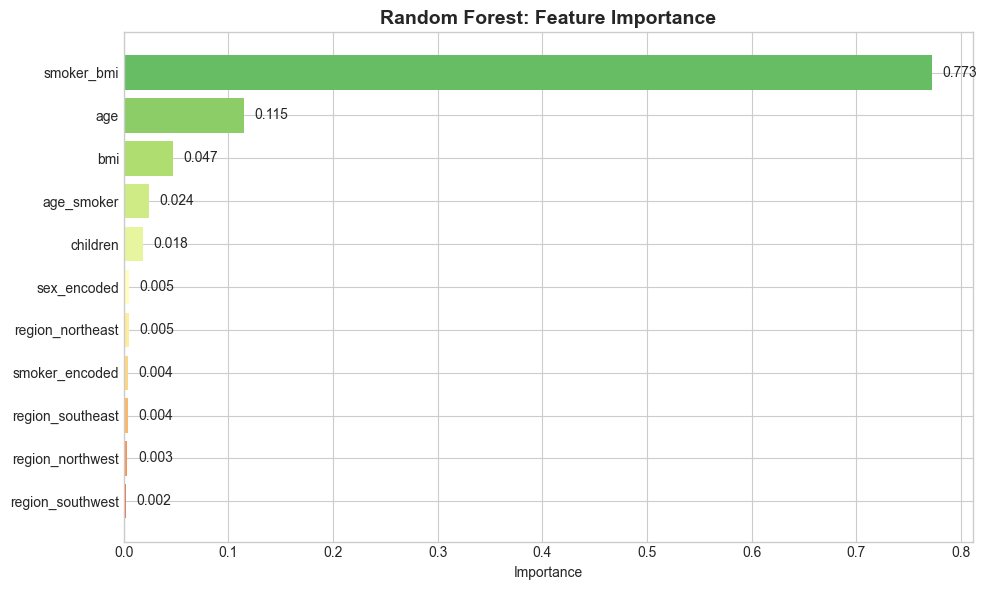


✅ Saved: model_feature_importance_rf.png


In [16]:
# Get feature importance from tree-based models
print("="*70)
print("                  FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Random Forest Feature Importance
rf_model = trained_reg_models['Random Forest']
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(feature_importance.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(feature_importance)))
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_title('Random Forest: Feature Importance', fontweight='bold', fontsize=14)
ax.invert_yaxis()

for bar, val in zip(bars, feature_importance['Importance']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center')

plt.tight_layout()
plt.savefig('../reports/figures/model_feature_importance_rf.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Saved: model_feature_importance_rf.png")

In [17]:
# SHAP Analysis (if available)
if SHAP_AVAILABLE:
    print("\n" + "="*70)
    print("                      SHAP ANALYSIS")
    print("="*70)
    
    # Use Random Forest for SHAP
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
    plt.title('SHAP Summary Plot - Random Forest', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig('../reports/figures/model_shap_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved: model_shap_summary.png")
else:
    print("\n⚠️ SHAP not available. Install with: pip install shap")


⚠️ SHAP not available. Install with: pip install shap


In [18]:
# SHAP Bar Plot - Top Features
if SHAP_AVAILABLE:
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_cols, 
                      plot_type='bar', show=False)
    plt.title('SHAP Feature Importance (Mean |SHAP|)', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig('../reports/figures/model_shap_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved: model_shap_importance.png")

In [19]:
# SHAP Dependence Plots for top features
if SHAP_AVAILABLE:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    top_features = feature_importance['Feature'].head(4).tolist()
    
    for idx, feature in enumerate(top_features):
        ax = axes[idx // 2, idx % 2]
        feature_idx = feature_cols.index(feature)
        shap.dependence_plot(feature_idx, shap_values, X_test, 
                            feature_names=feature_cols, ax=ax, show=False)
        ax.set_title(f'SHAP Dependence: {feature}', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/model_shap_dependence.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved: model_shap_dependence.png")

## 6. Model Summary & Business Recommendations

In [20]:
print("\n" + "="*70)
print("                    MODEL PERFORMANCE SUMMARY")
print("="*70)

print("\n📊 REGRESSION MODELS (Predicting Insurance Charges)")
print("-"*60)
print(reg_results_df.to_string(index=False))

print(f"\n🏆 Best Regression Model: {reg_results_df.iloc[0]['Model']}")
print(f"   - R² Score: {reg_results_df.iloc[0]['R²']:.4f}")
print(f"   - RMSE: ${reg_results_df.iloc[0]['RMSE']:,.2f}")

print("\n📊 CLASSIFICATION MODELS (Predicting High-Risk)")
print("-"*60)
print(clf_results_df.to_string(index=False))

print(f"\n🏆 Best Classification Model: {clf_results_df.iloc[0]['Model']}")
print(f"   - AUC-ROC: {clf_results_df.iloc[0]['AUC-ROC']:.4f}")
print(f"   - F1-Score: {clf_results_df.iloc[0]['F1-Score']:.4f}")


                    MODEL PERFORMANCE SUMMARY

📊 REGRESSION MODELS (Predicting Insurance Charges)
------------------------------------------------------------
            Model        RMSE       R²         MAE  CV_R2_Mean  CV_R2_Std
    Random Forest 4551.013126 0.866590 2517.744139    0.832332   0.042047
Linear Regression 4574.123734 0.865232 2757.759204    0.827932   0.045190
    Decision Tree 5789.938300 0.784067 2969.894757    0.729428   0.061228

🏆 Best Regression Model: Random Forest
   - R² Score: 0.8666
   - RMSE: $4,551.01

📊 CLASSIFICATION MODELS (Predicting High-Risk)
------------------------------------------------------------
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.914179   0.889764 0.926230  0.907631 0.959353
      Random Forest  0.936567   0.956522 0.901639  0.928270 0.951437
      Decision Tree  0.910448   0.901639 0.901639  0.901639 0.904755

🏆 Best Classification Model: Logistic Regression
   - AUC-ROC: 0.9594
   - 

In [21]:
print("\n" + "="*70)
print("                    BUSINESS RECOMMENDATIONS")
print("="*70)

# Get top 5 features
top_5_features = feature_importance.head(5)

print("""
📈 TOP 5 RISK DRIVERS (from SHAP/Feature Importance):
""")

for i, row in top_5_features.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    print(f"   {i+1}. {feature}: {importance:.3f} importance")

print("""
💼 BUSINESS INTERPRETATION:

1. SMOKER_BMI INTERACTION (Highest Impact)
   - The combination of smoking and high BMI is the strongest predictor
   - For every unit increase in BMI for smokers, charges increase significantly
   - Recommendation: Implement combined smoking+BMI premium adjustments

2. SMOKER STATUS
   - Smoking alone is a major risk factor
   - Smokers should be in a higher premium tier
   - Consider smoking cessation incentive programs

3. AGE
   - Older policyholders have higher predicted charges
   - Age-based premium scaling is justified by data
   
4. BMI
   - Independent effect of BMI on charges
   - Wellness programs targeting healthy weight can reduce risk

5. REGIONAL FACTORS
   - Some regional variation exists
   - Consider regional risk adjustments where significant

🎯 PRICING FRAMEWORK:

   Premium = Base_Premium × Age_Factor × Smoker_Factor × BMI_Factor × Region_Factor
   
   Where:
   - Smoker_Factor: 3.0-4.0x for smokers
   - BMI_Factor: 1.0-1.5x based on BMI category
   - Age_Factor: 1.0-2.0x based on age group
   - Region_Factor: 0.95-1.05x based on region
""")


                    BUSINESS RECOMMENDATIONS

📈 TOP 5 RISK DRIVERS (from SHAP/Feature Importance):

   6. smoker_bmi: 0.773 importance
   1. age: 0.115 importance
   2. bmi: 0.047 importance
   7. age_smoker: 0.024 importance
   3. children: 0.018 importance

💼 BUSINESS INTERPRETATION:

1. SMOKER_BMI INTERACTION (Highest Impact)
   - The combination of smoking and high BMI is the strongest predictor
   - For every unit increase in BMI for smokers, charges increase significantly
   - Recommendation: Implement combined smoking+BMI premium adjustments

2. SMOKER STATUS
   - Smoking alone is a major risk factor
   - Smokers should be in a higher premium tier
   - Consider smoking cessation incentive programs

3. AGE
   - Older policyholders have higher predicted charges
   - Age-based premium scaling is justified by data

4. BMI
   - Independent effect of BMI on charges
   - Wellness programs targeting healthy weight can reduce risk

5. REGIONAL FACTORS
   - Some regional variation exists

In [22]:
# List all generated figures
import os

figures_dir = '../reports/figures'
model_figures = [f for f in os.listdir(figures_dir) if f.startswith('model_')]

print("\n" + "="*50)
print("         GENERATED VISUALIZATIONS")
print("="*50)
for fig in sorted(model_figures):
    print(f"   ✅ {fig}")
print(f"\n📁 Location: reports/figures/")
print(f"📊 Total Model Figures: {len(model_figures)}")


         GENERATED VISUALIZATIONS
   ✅ model_best_regression_analysis.png
   ✅ model_classification_comparison.png
   ✅ model_confusion_matrix.png
   ✅ model_feature_importance_rf.png
   ✅ model_regression_comparison.png

📁 Location: reports/figures/
📊 Total Model Figures: 5
